In [4]:
!pip install PyTDC

     ---------------------------------------- 0.0/107.7 kB ? eta -:--:--
     --- ------------------------------------ 10.2/107.7 kB ? eta -:--:--
     --------------------- --------------- 61.4/107.7 kB 656.4 kB/s eta 0:00:01
     ------------------------------------ 107.7/107.7 kB 885.7 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/20.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/20.5 MB 3.6 MB/s eta 0:00:06
      --------------------------------------- 0.4/20.5 MB 5.1 MB/s eta 0:00:04
     - -------------------------------------- 0.6/20.5 MB 4.9 MB/s eta 0:00:05
     - -------------------------------------- 0.9/20.5 MB 6.0 MB/s eta 0:00:04
     -- ------------------------------------- 1.4/20.5 MB 6.2 MB/s eta 0:00:04
     --- ------------------------------------ 2.0/20.5 MB 7.4 MB/s eta 0:00:03
     ---- -----------------------------------


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\pahad\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [5]:
from tdc import utils
names = utils.retrieve_benchmark_names('ADMET_Group')


In [9]:
!pip install tensorflow deepchem

     ---------------------------------------- 0.0/552.4 kB ? eta -:--:--
      --------------------------------------- 10.2/552.4 kB ? eta -:--:--
     -- ---------------------------------- 41.0/552.4 kB 393.8 kB/s eta 0:00:02
     -------- --------------------------- 122.9/552.4 kB 798.9 kB/s eta 0:00:01
     ----------- -------------------------- 174.1/552.4 kB 1.1 MB/s eta 0:00:01
     ------------- ---------------------- 204.8/552.4 kB 831.5 kB/s eta 0:00:01
     --------------------- ---------------- 307.2/552.4 kB 1.1 MB/s eta 0:00:01
     ----------------------------- -------- 430.1/552.4 kB 1.3 MB/s eta 0:00:01
     ------------------------------ ------- 450.6/552.4 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 552.4/552.4 kB 1.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\pahad\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [12]:
import deepchem as dc
from tdc.single_pred import ADME

# Load the dataset
data = ADME(name='CYP2C9_Substrate_CarbonMangels')
split = data.get_split()

# Featurize data
featurizer = dc.feat.OneHotFeaturizer()
train_features = featurizer.featurize(split['train']['Drug'])
test_features = featurizer.featurize(split['test']['Drug'])

# Inspect the shape of the features
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)


Found local copy...
Loading...
Done!


Train features shape: (468,)
Test features shape: (134,)


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert SMILES to one-hot encoded sequences
def one_hot_smiles(smiles_list, max_length):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(smiles_list)
    sequences = tokenizer.texts_to_sequences(smiles_list)
    one_hot = pad_sequences(sequences, maxlen=max_length, padding='post')
    return one_hot, tokenizer.word_index

# Determine max length for padding
max_smiles_length = max(len(s) for s in split['train']['Drug'])

# Apply one-hot encoding
train_smiles = split['train']['Drug']
test_smiles = split['test']['Drug']
train_features, _ = one_hot_smiles(train_smiles, max_smiles_length)
test_features, _ = one_hot_smiles(test_smiles, max_smiles_length)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)


Train features shape: (468, 225)
Test features shape: (134, 225)


In [19]:
import numpy as np

train_features = np.array(train_features)
test_features = np.array(test_features)


In [64]:
import numpy as np
import deepchem as dc
from tdc.single_pred import ADME
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
data = ADME(name='CYP2C9_Substrate_CarbonMangels')
split = data.get_split()

# Function to convert SMILES to one-hot encoded sequences
def one_hot_smiles(smiles_list, max_length):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(smiles_list)
    sequences = tokenizer.texts_to_sequences(smiles_list)
    one_hot = pad_sequences(sequences, maxlen=max_length, padding='post')
    return one_hot, tokenizer.word_index

# Determine max length for padding
max_smiles_length = max(len(s) for s in split['train']['Drug'])

# Apply one-hot encoding
train_smiles = split['train']['Drug']
test_smiles = split['test']['Drug']
train_features, _ = one_hot_smiles(train_smiles, max_smiles_length)
test_features, _ = one_hot_smiles(test_smiles, max_smiles_length)

# Ensure features are NumPy arrays
train_features = np.array(train_features)
test_features = np.array(test_features)

# Reshape features for LSTM input
train_features_lstm = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
test_features_lstm = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(max_smiles_length, 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_features_lstm, split['train']['Y'], epochs=50, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(test_features_lstm, split['test']['Y'])
print(f'Test Accuracy: {accuracy}')


Found local copy...
Loading...
Done!


Epoch 1/50
4/4 [==============================] - 4s 156ms/step - loss: 0.6882 - accuracy: 0.7927
Epoch 2/50
4/4 [==============================] - 1s 162ms/step - loss: 0.6719 - accuracy: 0.7927
Epoch 3/50
4/4 [==============================] - 1s 162ms/step - loss: 0.6381 - accuracy: 0.7927
Epoch 4/50
4/4 [==============================] - 1s 166ms/step - loss: 0.5556 - accuracy: 0.7927
Epoch 5/50
4/4 [==============================] - 1s 170ms/step - loss: 0.5189 - accuracy: 0.7927
Epoch 6/50
4/4 [==============================] - 1s 162ms/step - loss: 0.5118 - accuracy: 0.7927
Epoch 7/50
4/4 [==============================] - 1s 167ms/step - loss: 0.5138 - accuracy: 0.7927
Epoch 8/50
4/4 [==============================] - 1s 173ms/step - loss: 0.5151 - accuracy: 0.7927
Epoch 9/50
4/4 [==============================] - 1s 162ms/step - loss: 0.5121 - accuracy: 0.7927
Epoch 10/50
4/4 [==============================] - 1s 165ms/step - loss: 0.5102 - accuracy: 0.7927
Epoch 11/50
4/4 [==

In [38]:
import numpy as np
import deepchem as dc
from tdc.single_pred import ADME
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
data = ADME(name='CYP2C9_Substrate_CarbonMangels')
split = data.get_split()

# Function to convert SMILES to one-hot encoded sequences
def one_hot_smiles(smiles_list, max_length):
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(smiles_list)
    sequences = tokenizer.texts_to_sequences(smiles_list)
    one_hot = pad_sequences(sequences, maxlen=max_length, padding='post')
    return one_hot

# Determine max length for padding
max_smiles_length = max(len(s) for s in split['train']['Drug'])

# Apply one-hot encoding
train_smiles = split['train']['Drug']
test_smiles = split['test']['Drug']
train_features = one_hot_smiles(train_smiles, max_smiles_length)
test_features = one_hot_smiles(test_smiles, max_smiles_length)

# Ensure features are NumPy arrays
train_features = np.array(train_features)
test_features = np.array(test_features)

# Define the Feed-Forward Neural Network model
ffnn_model = Sequential()
ffnn_model.add(Flatten(input_shape=(max_smiles_length,)))
ffnn_model.add(Dense(128, activation='relu'))
ffnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
ffnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ffnn_model.fit(train_features, split['train']['Y'], epochs=50, batch_size=128)

# Evaluate the model
loss, accuracy = ffnn_model.evaluate(test_features, split['test']['Y'])
print(f'Test Accuracy: {accuracy}')


Found local copy...
Loading...
Done!


Epoch 1/50
4/4 [==============================] - 1s 5ms/step - loss: 0.9306 - accuracy: 0.6368
Epoch 2/50
4/4 [==============================] - 0s 0s/step - loss: 0.7809 - accuracy: 0.7778
Epoch 3/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6289 - accuracy: 0.7436
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6090 - accuracy: 0.6987
Epoch 5/50
4/4 [==============================] - 0s 0s/step - loss: 0.5293 - accuracy: 0.7543
Epoch 6/50
4/4 [==============================] - 0s 0s/step - loss: 0.4983 - accuracy: 0.7821
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.7906
Epoch 8/50
4/4 [==============================] - 0s 5ms/step - loss: 0.4177 - accuracy: 0.8184
Epoch 9/50
4/4 [==============================] - 0s 0s/step - loss: 0.3949 - accuracy: 0.8291
Epoch 10/50
4/4 [==============================] - 0s 5ms/step - loss: 0.3751 - accuracy: 0.8376
Epoch 11/50
4/4 [==========================

5/5 [==============================] - 0s 26ms/step
Confusion Matrix:
 [[107   0]
 [ 27   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       107
           1       0.00      0.00      0.00        27

    accuracy                           0.80       134
   macro avg       0.40      0.50      0.44       134
weighted avg       0.64      0.80      0.71       134



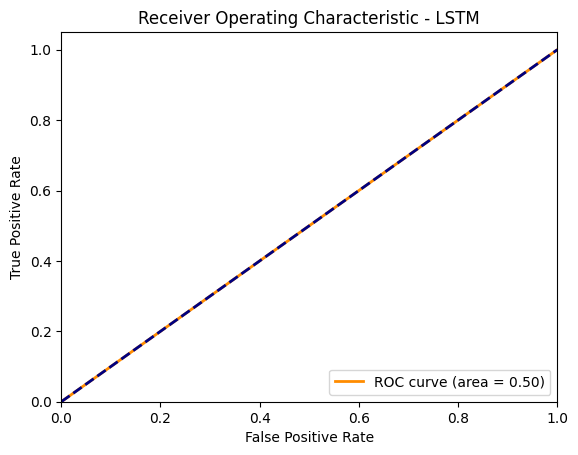

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predictions
lstm_predictions = model.predict(test_features_lstm)
lstm_predictions = (lstm_predictions > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(split['test']['Y'], lstm_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("\nClassification Report:\n", classification_report(split['test']['Y'], lstm_predictions))

# ROC Curve
fpr, tpr, thresholds = roc_curve(split['test']['Y'], lstm_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LSTM')
plt.legend(loc="lower right")
plt.show()


5/5 [==============================] - 0s 0s/step
Confusion Matrix:
 [[91 16]
 [23  4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       107
           1       0.20      0.15      0.17        27

    accuracy                           0.71       134
   macro avg       0.50      0.50      0.50       134
weighted avg       0.68      0.71      0.69       134



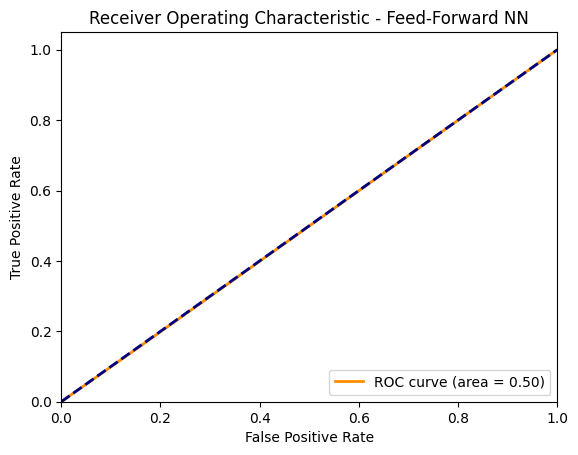

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Predictions with Feed-Forward Neural Network model
ffnn_predictions = ffnn_model.predict(test_features)
ffnn_predictions = (ffnn_predictions > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(split['test']['Y'], ffnn_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("\nClassification Report:\n", classification_report(split['test']['Y'], ffnn_predictions))

# ROC Curve
fpr, tpr, thresholds = roc_curve(split['test']['Y'], ffnn_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Feed-Forward NN')
plt.legend(loc="lower right")
plt.show()


In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import numpy as np

# Predictions with Feed-Forward Neural Network model
ffnn_predictions = ffnn_model.predict(test_features)
ffnn_predictions_binary = (ffnn_predictions > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(split['test']['Y'], ffnn_predictions_binary)

# Extracting True Positives, True Negatives, False Positives, False Negatives
tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

# Calculating metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # Also known as Recall
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(split['test']['Y'], ffnn_predictions_binary)
auc = roc_auc_score(split['test']['Y'], ffnn_predictions)

# Print metrics
print(f"Loss: {loss}")
print(f"Accuracy (ACC): {accuracy}")
print(f"AUC: {auc}")
print(f"Sensitivity (Sen): {sensitivity}")
print(f"Specificity (Spe): {specificity}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")


5/5 [==============================] - 0s 992us/step
Loss: 0.8945853114128113
Accuracy (ACC): 0.7238805970149254
AUC: 0.6216683973693319
Sensitivity (Sen): 0.1111111111111111
Specificity (Spe): 0.8785046728971962
Matthews Correlation Coefficient (MCC): -0.012845366171167993


In [44]:
# Train the model and capture history
history = ffnn_model.fit(train_features, split['train']['Y'], 
                         epochs=50, batch_size=128,
                         validation_data=(test_features, split['test']['Y']),
                         verbose=1)


Epoch 1/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0774 - accuracy: 0.9979 - val_loss: 0.9430 - val_accuracy: 0.7313
Epoch 2/50
4/4 [==============================] - 0s 11ms/step - loss: 0.0751 - accuracy: 0.9979 - val_loss: 0.9461 - val_accuracy: 0.7313
Epoch 3/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0730 - accuracy: 0.9979 - val_loss: 0.9503 - val_accuracy: 0.7239
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0710 - accuracy: 0.9979 - val_loss: 0.9559 - val_accuracy: 0.7239
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0694 - accuracy: 0.9979 - val_loss: 0.9587 - val_accuracy: 0.7313
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.0670 - accuracy: 0.9979 - val_loss: 0.9658 - val_accuracy: 0.7239
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 0.0656 - accuracy: 0.9979 - val_loss: 0.9705 - val_accuracy: 0.7239
Epoch 8/50
4/4 [===========

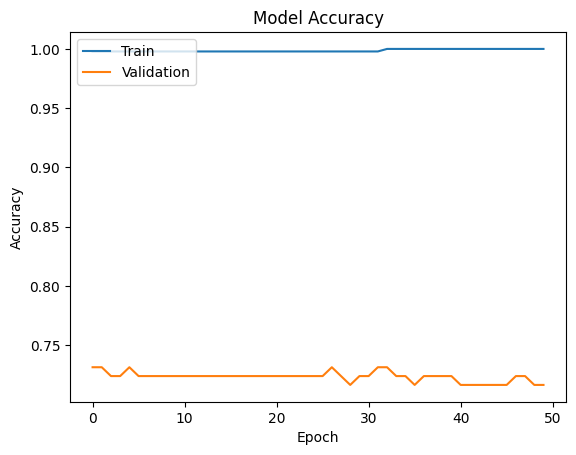

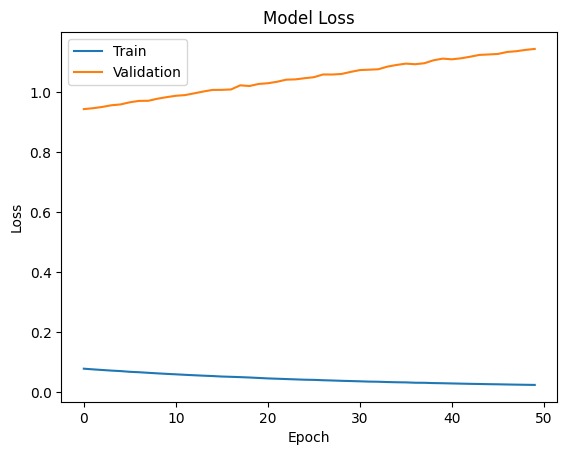

In [45]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [46]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

class RocAucCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train = training_data[0]
        self.y_train = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.train_auc = []
        self.val_auc = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = self.model.predict(self.x_train)
        val_pred = self.model.predict(self.x_val)
        train_auc = roc_auc_score(self.y_train, train_pred)
        val_auc = roc_auc_score(self.y_val, val_pred)
        self.train_auc.append(train_auc)
        self.val_auc.append(val_auc)
        print(f'\nEpoch {epoch + 1}: train_auc: {train_auc}, val_auc: {val_auc}')


In [47]:
roc_auc_callback = RocAucCallback(training_data=(train_features, split['train']['Y']),
                                  validation_data=(test_features, split['test']['Y']))

history = ffnn_model.fit(train_features, split['train']['Y'], 
                         epochs=50, batch_size=128,
                         validation_data=(test_features, split['test']['Y']),
                         callbacks=[roc_auc_callback],
                         verbose=1)

Epoch 1/50
5/5 [==============================] - 0s 1ms/step

Epoch 1: train_auc: 1.0, val_auc: 0.6237452405676704
4/4 [==============================] - 0s 88ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 1.1497 - val_accuracy: 0.7164
Epoch 2/50
5/5 [==============================] - 0s 1ms/step

Epoch 2: train_auc: 1.0, val_auc: 0.6237452405676704
4/4 [==============================] - 0s 73ms/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 1.1525 - val_accuracy: 0.7164
Epoch 3/50
5/5 [==============================] - 0s 1ms/step

Epoch 3: train_auc: 1.0, val_auc: 0.6237452405676704
4/4 [==============================] - 0s 65ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 1.1556 - val_accuracy: 0.7164
Epoch 4/50
5/5 [==============================] - 0s 2ms/step

Epoch 4: train_auc: 1.0, val_auc: 0.6227068189685012
4/4 [==============================] - 0s 66ms/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 1.1579 - val_accuracy: 0.7164
Epoch 5/50
5/5 [========

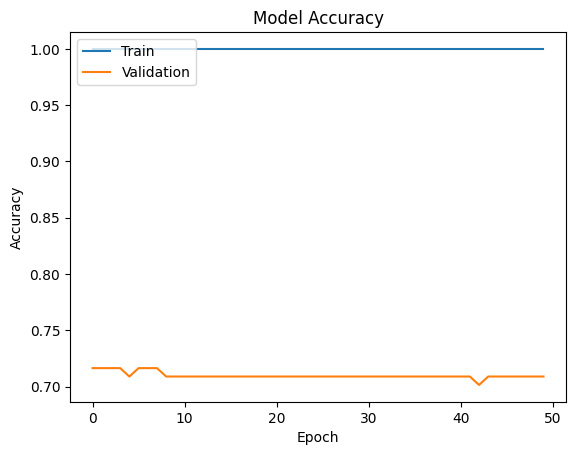

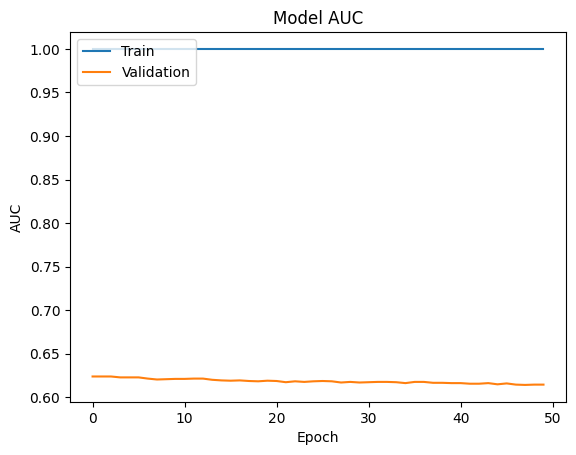

In [48]:
# Plotting Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting AUC
plt.plot(roc_auc_callback.train_auc)
plt.plot(roc_auc_callback.val_auc)
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef

class MetricsCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train = training_data[0]
        self.y_train = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.train_sen = []
        self.val_sen = []
        self.train_spe = []
        self.val_spe = []
        self.train_mcc = []
        self.val_mcc = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = (self.model.predict(self.x_train) > 0.5).astype(int)
        val_pred = (self.model.predict(self.x_val) > 0.5).astype(int)

        # Compute confusion matrix for both train and validation sets
        train_cm = confusion_matrix(self.y_train, train_pred)
        val_cm = confusion_matrix(self.y_val, val_pred)

        # Calculate metrics
        train_sen, train_spe = self.calculate_sen_spe(train_cm)
        val_sen, val_spe = self.calculate_sen_spe(val_cm)

        train_mcc = matthews_corrcoef(self.y_train, train_pred)
        val_mcc = matthews_corrcoef(self.y_val, val_pred)

        # Append metrics to lists
        self.train_sen.append(train_sen)
        self.val_sen.append(val_sen)
        self.train_spe.append(train_spe)
        self.val_spe.append(val_spe)
        self.train_mcc.append(train_mcc)
        self.val_mcc.append(val_mcc)

    def calculate_sen_spe(self, cm):
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        return sensitivity, specificity


In [50]:
metrics_callback = MetricsCallback(training_data=(train_features, split['train']['Y']),
                                   validation_data=(test_features, split['test']['Y']))

history = ffnn_model.fit(train_features, split['train']['Y'], 
                         epochs=50, batch_size=128,
                         validation_data=(test_features, split['test']['Y']),
                         callbacks=[metrics_callback],
                         verbose=1)


Epoch 1/50
4/4 [==============================] - 0s 78ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 1.3123 - val_accuracy: 0.7090
Epoch 2/50
4/4 [==============================] - 0s 63ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 1.3172 - val_accuracy: 0.7090
Epoch 3/50
4/4 [==============================] - 0s 63ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 1.3210 - val_accuracy: 0.7090
Epoch 4/50
4/4 [==============================] - 0s 63ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.3205 - val_accuracy: 0.7015
Epoch 5/50
4/4 [==============================] - 0s 68ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.3230 - val_accuracy: 0.7015
Epoch 6/50
4/4 [==============================] - 0s 63ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 1.3286 - val_accuracy: 0.7015
Epoch 7/50
4/4 [==============================] - 0s 68ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.3317 - val_accuracy: 0.7090
Epoch 8/50
4/4 [===========

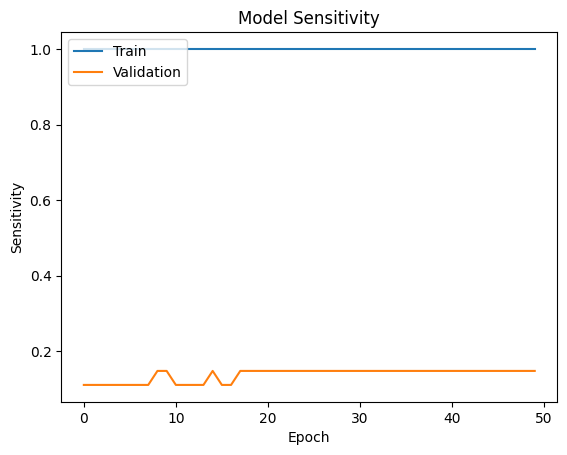

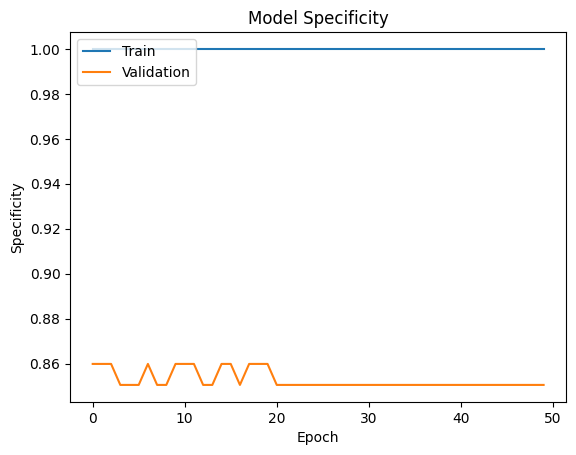

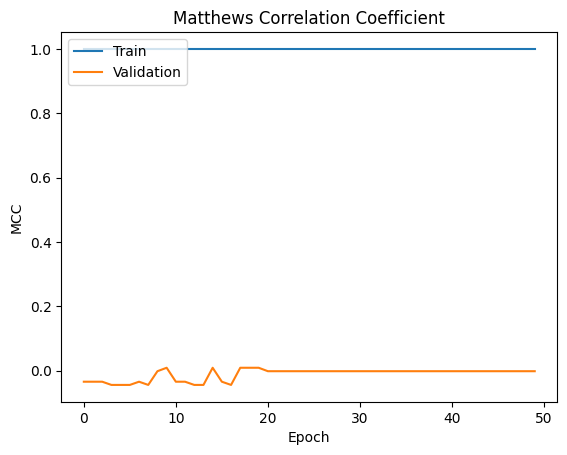

In [51]:
# Plotting Sensitivity
plt.plot(metrics_callback.train_sen)
plt.plot(metrics_callback.val_sen)
plt.title('Model Sensitivity')
plt.ylabel('Sensitivity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Specificity
plt.plot(metrics_callback.train_spe)
plt.plot(metrics_callback.val_spe)
plt.title('Model Specificity')
plt.ylabel('Specificity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Matthews Correlation Coefficient
plt.plot(metrics_callback.train_mcc)
plt.plot(metrics_callback.val_mcc)
plt.title('Matthews Correlation Coefficient')
plt.ylabel('MCC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [52]:
#Plots for LSTM

In [53]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, matthews_corrcoef

class LSTM_MetricsCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train = training_data[0]
        self.y_train = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.train_sen = []
        self.val_sen = []
        self.train_spe = []
        self.val_spe = []
        self.train_mcc = []
        self.val_mcc = []

    def on_epoch_end(self, epoch, logs=None):
        train_pred = (self.model.predict(self.x_train) > 0.5).astype(int)
        val_pred = (self.model.predict(self.x_val) > 0.5).astype(int)

        # Compute confusion matrix for both train and validation sets
        train_cm = confusion_matrix(self.y_train, train_pred)
        val_cm = confusion_matrix(self.y_val, val_pred)

        # Calculate metrics
        train_sen, train_spe = self.calculate_sen_spe(train_cm)
        val_sen, val_spe = self.calculate_sen_spe(val_cm)

        train_mcc = matthews_corrcoef(self.y_train, train_pred)
        val_mcc = matthews_corrcoef(self.y_val, val_pred)

        # Append metrics to lists
        self.train_sen.append(train_sen)
        self.val_sen.append(val_sen)
        self.train_spe.append(train_spe)
        self.val_spe.append(val_spe)
        self.train_mcc.append(train_mcc)
        self.val_mcc.append(val_mcc)

    def calculate_sen_spe(self, cm):
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        return sensitivity, specificity

In [57]:
lstm_metrics_callback = LSTM_MetricsCallback(training_data=(train_features_lstm, split['train']['Y']),
                                             validation_data=(test_features_lstm, split['test']['Y']))

lstm_history = model.fit(train_features_lstm, split['train']['Y'], 
                              epochs=20, batch_size=128,
                              validation_data=(test_features_lstm, split['test']['Y']),
                              callbacks=[lstm_metrics_callback],
                              verbose=1)


Epoch 1/20
4/4 [==============================] - 2s 471ms/step - loss: 0.5099 - accuracy: 0.7927 - val_loss: 0.5024 - val_accuracy: 0.7985
Epoch 2/20
4/4 [==============================] - 2s 440ms/step - loss: 0.5102 - accuracy: 0.7927 - val_loss: 0.5025 - val_accuracy: 0.7985
Epoch 3/20
4/4 [==============================] - 2s 451ms/step - loss: 0.5096 - accuracy: 0.7927 - val_loss: 0.5025 - val_accuracy: 0.7985
Epoch 4/20
4/4 [==============================] - 2s 445ms/step - loss: 0.5101 - accuracy: 0.7927 - val_loss: 0.5024 - val_accuracy: 0.7985
Epoch 5/20
4/4 [==============================] - 2s 445ms/step - loss: 0.5097 - accuracy: 0.7927 - val_loss: 0.5025 - val_accuracy: 0.7985
Epoch 6/20
4/4 [==============================] - 2s 445ms/step - loss: 0.5095 - accuracy: 0.7927 - val_loss: 0.5027 - val_accuracy: 0.7985
Epoch 7/20
4/4 [==============================] - 1s 435ms/step - loss: 0.5100 - accuracy: 0.7927 - val_loss: 0.5033 - val_accuracy: 0.7985
Epoch 8/20
4/4 [====

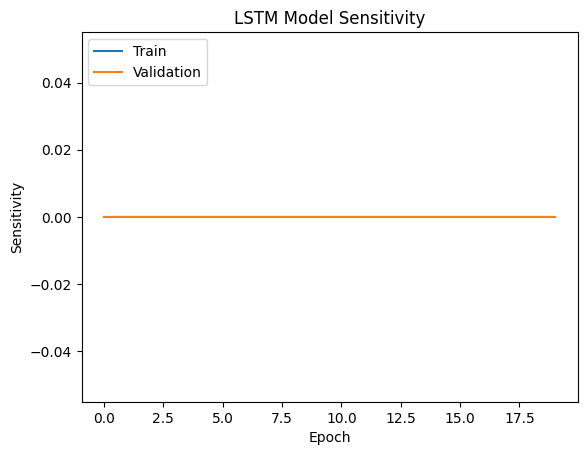

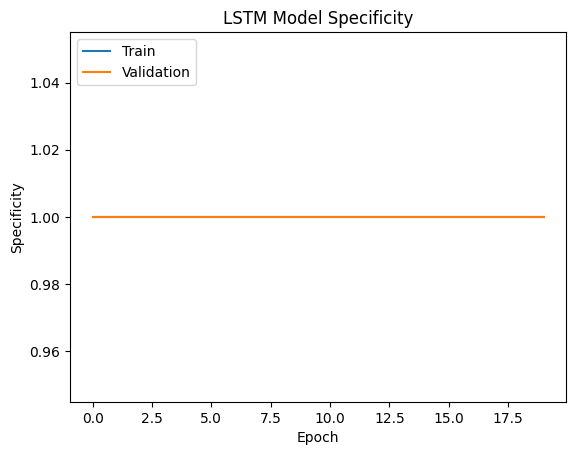

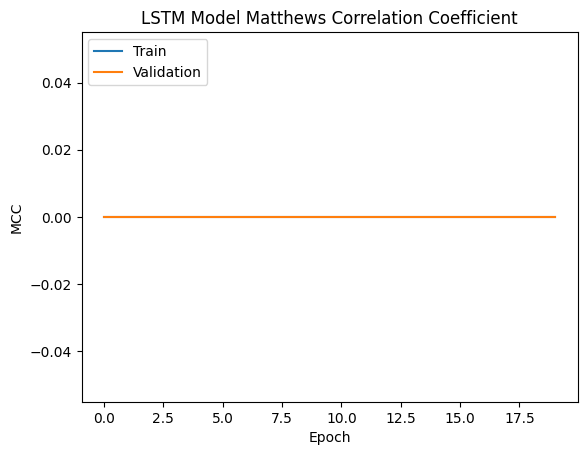

In [69]:
# Plotting Sensitivity
plt.plot(lstm_metrics_callback.train_sen)
plt.plot(lstm_metrics_callback.val_sen)
plt.title('LSTM Model Sensitivity')
plt.ylabel('Sensitivity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Specificity
plt.plot(lstm_metrics_callback.train_spe)
plt.plot(lstm_metrics_callback.val_spe)
plt.title('LSTM Model Specificity')
plt.ylabel('Specificity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Matthews Correlation Coefficient
plt.plot(lstm_metrics_callback.train_mcc)
plt.plot(lstm_metrics_callback.val_mcc)
plt.title('LSTM Model Matthews Correlation Coefficient')
plt.ylabel('MCC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()